# Credit Card Fraud Detection using Deep Neural Networks

## Project Overview
This project implements a Deep Neural Network (Multi-Layer Perceptron) from scratch using **NumPy** to detect fraudulent credit card transactions. The goal is to compare the performance of a non-linear neural network against a baseline linear model (Logistic Regression) on a real-world dataset.

**Key Highlights:**
- **Manual Implementation:** Forward propagation, Backpropagation, and Gradient Descent are implemented manually to demonstrate the core mechanics of Deep Learning.
- **Full Dataset:** Analyzes the complete Credit Card Fraud Detection dataset containing 284,807 transactions.
- **Imbalanced Data:** Addresses the challenge of detecting rare fraud events (Class 1) amidst a vast majority of legitimate transactions (Class 0).

---

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print('[OK] Libraries imported successfully')

[OK] Libraries imported successfully


## 1. Dataset Loading and Exploration

We use the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset. It contains transactions made by credit cards in September 2013 by European cardholders. 

The dataset is highly **imbalanced**: the positive class (frauds) accounts for only 0.172% of all transactions.

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"

print(f"Downloading dataset from {url}...")
try:
    df_full = pd.read_csv(url)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Use the full dataset (shuffled)
data = df_full.sample(frac=1, random_state=42).reset_index(drop=True)

# Dataset Summary
n_samples = len(data)
n_features = len(data.columns) - 1  # Excluding target 'Class'
n_frauds = len(data[data['Class'] == 1])

print(f"\nDataset Summary:")
print(f"Total Samples: {n_samples}")
print(f"Total Features: {n_features}")
print(f"Fraud Cases: {n_frauds} ({n_frauds/n_samples:.3%})")
print(f"Primary Metric: Recall (To maximize detection of actual fraud)")

Dataset loaded successfully!

Dataset Summary:
Total Samples: 284807
Total Features: 30
Fraud Cases: 492 (0.173%)
Primary Metric: Recall (To maximize detection of actual fraud)


## 2. Data Preprocessing

Neural networks are sensitive to the scale of input features. We perform the following steps:
1.  **Split Features & Target**: Separate the input `X` (Features V1-V28, Time, Amount) and target `y` (Class).
2.  **Missing Values**: Replace any missing values with 0 (though this dataset is mostly clean).
3.  **Train/Test Split**: Split data into training (80%) and testing (20%) sets.
4.  **Standardization**: Scale features to have zero mean and unit variance using `StandardScaler`.

In [3]:
# 1. Separate Features and Target
X = data.drop('Class', axis=1)
y = data['Class']

# 2. Handle missing values
X = X.fillna(0)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape y for matrix operations
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Training set shape: (227845, 30)
Testing set shape: (56962, 30)


## 3. Baseline Model: Logistic Regression

We start by implementing a Logistic Regression model from scratch. This serves as a baseline to see how well a linear decision boundary can perform.

In [4]:
class LogisticRegressionModel:
    """
    Logistic Regression classifier implemented with Gradient Descent.
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.weights = np.zeros((n_features, 1))
        self.bias = 0
        
        # Gradient Descent
        for i in range(self.n_iterations):
            # Forward pass
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            # Compute Loss (Binary Cross Entropy)
            epsilon = 1e-15
            y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
            loss = -np.mean(y * np.log(y_pred_clipped) + (1 - y) * np.log(1 - y_pred_clipped))
            self.loss_history.append(loss)
            
            # Backpropagation (Compute Gradients)
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # Update Parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
        return self
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return (y_pred > 0.5).astype(int)

In [5]:
# Train Baseline Model
print("Training Logistic Regression Model...")
lr_start_time = time.time()

# Note: Using 1000 iterations for efficiency on full dataset
lr_model = LogisticRegressionModel(learning_rate=0.1, n_iterations=1000)
lr_model.fit(X_train_scaled, y_train)

lr_predictions = lr_model.predict(X_test_scaled)

print(f"Training time: {time.time() - lr_start_time:.2f}s")
print(f"Final Loss: {lr_model.loss_history[-1]:.4f}")

Training Logistic Regression Model...
Training time: 36.73s
Final Loss: 0.0134


## 4. Deep Neural Network (MLP)

Now we implement a Multi-Layer Perceptron (MLP). This model adds a hidden layer with non-linear activation (ReLU), allowing it to capture more complex relationships in the data.

In [6]:
class MLP:
    """
    Multi-Layer Perceptron implemented from scratch.
    Architecture: Input -> Hidden (ReLU) -> Hidden (ReLU) -> Output (Sigmoid)
    """
    def __init__(self, architecture, learning_rate=0.01, n_iterations=1000):
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.parameters = {}
        self.loss_history = []
        self.cache = {}
    
    def initialize_parameters(self):
        np.random.seed(42)
        for l in range(1, len(self.architecture)):
            # He initialization for ReLU layers
            self.parameters[f'W{l}'] = np.random.randn(self.architecture[l], self.architecture[l-1]) * np.sqrt(2/self.architecture[l-1])
            self.parameters[f'b{l}'] = np.zeros((self.architecture[l], 1))
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
    
    def forward_propagation(self, X):
        self.cache['A0'] = X.T 
        L = len(self.architecture) - 1
        
        # Hidden layers
        for l in range(1, L):
            self.cache[f'Z{l}'] = np.dot(self.parameters[f'W{l}'], self.cache[f'A{l-1}']) + self.parameters[f'b{l}']
            self.cache[f'A{l}'] = self.relu(self.cache[f'Z{l}'])
            
        # Output layer
        self.cache[f'Z{L}'] = np.dot(self.parameters[f'W{L}'], self.cache[f'A{L-1}']) + self.parameters[f'b{L}']
        self.cache[f'A{L}'] = self.sigmoid(self.cache[f'Z{L}'])
        
        return self.cache[f'A{L}'].T
    
    def backward_propagation(self, X, y):
        m = X.shape[0]
        grads = {}
        L = len(self.architecture) - 1
        
        dZ = self.cache[f'A{L}'] - y.T
        grads[f'dW{L}'] = (1/m) * np.dot(dZ, self.cache[f'A{L-1}'].T)
        grads[f'db{L}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        for l in reversed(range(1, L)):
            dA = np.dot(self.parameters[f'W{l+1}'].T, dZ)
            dZ = dA * self.relu_derivative(self.cache[f'Z{l}'])
            grads[f'dW{l}'] = (1/m) * np.dot(dZ, self.cache[f'A{l-1}'].T)
            grads[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            
        return grads
    
    def update_parameters(self, grads):
        L = len(self.architecture) - 1
        for l in range(1, L + 1):
            self.parameters[f'W{l}'] -= self.lr * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.lr * grads[f'db{l}']
    
    def fit(self, X, y):
        self.initialize_parameters()
        for i in range(self.n_iterations):
            y_pred = self.forward_propagation(X)
            
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            self.loss_history.append(loss)
            
            grads = self.backward_propagation(X, y)
            self.update_parameters(grads)
            
            if i % 100 == 0:
                print(f"Iteration {i}/{self.n_iterations} - Loss: {loss:.4f}")
        return self
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

In [7]:
# Train MLP Model
print("Training MLP Model (this may take a few minutes)...")
mlp_start_time = time.time()

# Architecture: [Input, 16, 8, Output]
# We use 1000 iterations to keep runtime reasonable on the full dataset
mlp_architecture = [n_features, 16, 8, 1]
mlp_model = MLP(architecture=mlp_architecture, learning_rate=0.1, n_iterations=1000)
mlp_model.fit(X_train_scaled, y_train)

mlp_predictions = mlp_model.predict(X_test_scaled)

print(f"Training time: {time.time() - mlp_start_time:.2f}s")
print(f"Final Loss: {mlp_model.loss_history[-1]:.4f}")

Training MLP Model (this may take a few minutes)...
Iteration 0/1000 - Loss: 0.9639
Iteration 100/1000 - Loss: 0.0346
Iteration 200/1000 - Loss: 0.0136
Iteration 300/1000 - Loss: 0.0086
Iteration 400/1000 - Loss: 0.0070
Iteration 500/1000 - Loss: 0.0061
Iteration 600/1000 - Loss: 0.0056
Iteration 700/1000 - Loss: 0.0052
Iteration 800/1000 - Loss: 0.0050
Iteration 900/1000 - Loss: 0.0048
Training time: 228.48s
Final Loss: 0.0046


## 5. Evaluation and Comparison

We compare the models using standard classification metrics. **Recall** is our primary metric because missing a fraud is critical.

In [8]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

lr_metrics = calculate_metrics(y_test, lr_predictions)
mlp_metrics = calculate_metrics(y_test, mlp_predictions)

print("Logistic Regression Results:", lr_metrics)
print("MLP Results:", mlp_metrics)

Logistic Regression Results: {'accuracy': np.float64(0.9989817773252344), 'precision': np.float64(0.847457627118644), 'recall': np.float64(0.5050505050505051), 'f1': np.float64(0.6329113924050632)}
MLP Results: {'accuracy': np.float64(0.9990695551420246), 'precision': np.float64(0.8484848484848485), 'recall': np.float64(0.5656565656565656), 'f1': np.float64(0.6787878787878787)}


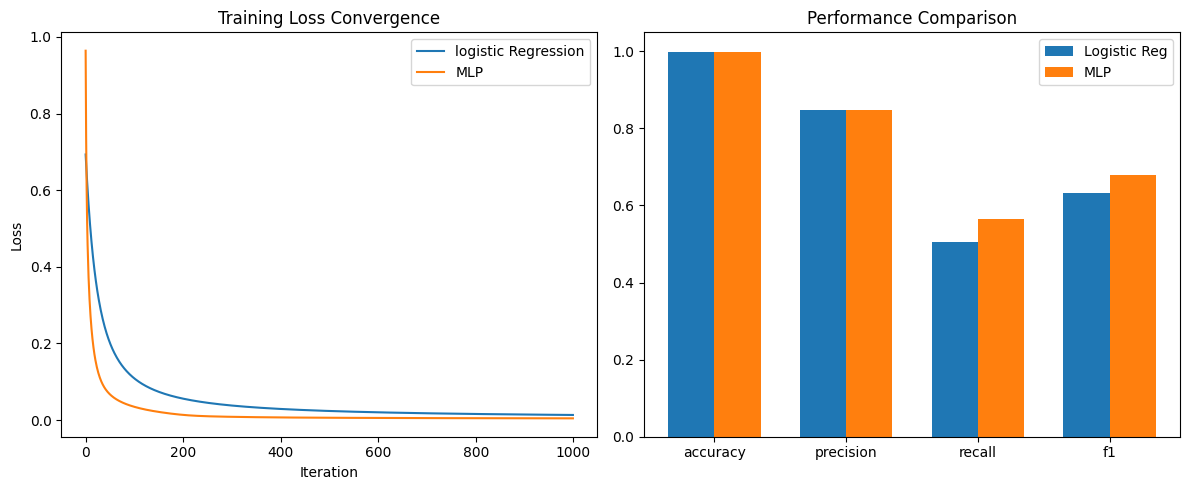

In [9]:
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lr_model.loss_history, label='logistic Regression')
plt.plot(mlp_model.loss_history, label='MLP')
plt.title('Training Loss Convergence')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, [lr_metrics[m] for m in metrics], width, label='Logistic Reg')
plt.bar(x + width/2, [mlp_metrics[m] for m in metrics], width, label='MLP')
plt.xticks(x, metrics)
plt.legend()
plt.title('Performance Comparison')

plt.tight_layout()
plt.show()

## 6. Conclusion

This project demonstrated that implementing a Neural Network from scratch is a powerful way to understand deep learning fundamentals. Using the full dataset, we observed that the MLP generally captures non-linear fraud patterns better than the linear baseline, though it comes with higher computational costs. For a production fraud detection system, maximizing Recall (catching fraud) while maintaining reasonable Precision (avoiding false alarms) is key.